<a href="https://colab.research.google.com/github/shubhamt2897/DL_BB/blob/main/DL_Bounding_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Dependencies

In [ ]:
!pip install --upgrade torch torchvision
!pip install numpy matplotlib albumentations kornia open3d gdown



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!nvidia-smi


Download & Extract Your Dataset

In [1]:
# Download from Google Drive using gdown
!gdown "https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb" -O dl_challenge.tar.xz

# Extract the .tar.xz file
!tar -xvf dl_challenge.tar.xz  # This should create a dl_challenge/ directory


Downloading...
From (original): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb
From (redirected): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb&confirm=t&uuid=0d65086f-9eca-47b8-8a42-e863be843f96
To: /content/dl_challenge.tar.xz
100% 2.44G/2.44G [00:33<00:00, 73.2MB/s]
dl_challenge/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/rgb.jp

In [2]:
import os
import glob

data_dir = 'dl_challenge'  # or the path where dl_challenge is located
folders = sorted(glob.glob(os.path.join(data_dir, '*')))
print("Number of data folders:", len(folders))
print("First folder name:", folders[0])
print("Files in the first folder:", os.listdir(folders[0]))



Number of data folders: 200
First folder name: dl_challenge/859074c2-9915-11ee-9103-bbb8eae05561
Files in the first folder: ['mask.npy', 'pc.npy', 'rgb.jpg', 'bbox3d.npy']


**Dataset & Preprocessing**

In [3]:
import os

folder_path = 'dl_challenge/96e66c6d-9915-11ee-9103-bbb8eae05561'
print("Files in the folder:", os.listdir(folder_path))


Files in the folder: ['mask.npy', 'pc.npy', 'rgb.jpg', 'bbox3d.npy']


**Data Loading, Model Definition & Training Setup**

 Create a PyTorch Dataset Class

In [4]:
import torch
from torch.utils.data import Dataset
import albumentations as A
import cv2
import numpy as np
import os

class Sereact3DDataset(Dataset):
    def __init__(self, folder_list, transform=None):
        self.folder_list = folder_list
        self.transform = transform

        # Filter folders to include only those with all required files.
        self.folder_list = [
            folder for folder in self.folder_list
            if all(os.path.isfile(os.path.join(folder, fname))
                   for fname in ['rgb.jpg', 'bbox3d.npy', 'mask.npy', 'pc.npy'])
        ]

    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        folder_path = self.folder_list[idx]
        rgb_path   = os.path.join(folder_path, 'rgb.jpg')
        bbox_path  = os.path.join(folder_path, 'bbox3d.npy')
        mask_path  = os.path.join(folder_path, 'mask.npy')
        pc_path    = os.path.join(folder_path, 'pc.npy')

        # Load files
        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # Convert BGR to RGB
        bbox3d = np.load(bbox_path)
        mask = np.load(mask_path)
        point_cloud = np.load(pc_path)

        # If point_cloud is image-like (shape: [3, H, W]), convert it.
        if point_cloud.ndim == 3 and point_cloud.shape[0] == 3:
            point_cloud = np.transpose(point_cloud, (1, 2, 0))
            point_cloud = point_cloud.reshape(-1, 3)

        # Apply transform to RGB if provided.
        if self.transform:
            augmented = self.transform(image=rgb)
            rgb = augmented['image']

        # Convert to torch tensors
        rgb = torch.from_numpy(rgb).permute(2, 0, 1).float()  # (C, H, W)
        bbox3d = torch.from_numpy(bbox3d).float()
        mask = torch.from_numpy(mask).float()
        point_cloud = torch.from_numpy(point_cloud).float()  # Expected: [N, 3]

        return {
            'rgb': rgb,
            'bbox3d': bbox3d,
            'mask': mask,
            'point_cloud': point_cloud
        }


**Define Transforms and Create DataLoaders**

In [5]:
import glob
from torch.utils.data import DataLoader
import albumentations as A

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])
val_transform = A.Compose([A.Resize(224, 224)])

data_dir = 'dl_challenge'
folders = sorted(glob.glob(os.path.join(data_dir, '*')))

train_folders = folders[:150]
val_folders = folders[150:180]
test_folders = folders[180:]

train_dataset = Sereact3DDataset(train_folders, transform=train_transform)
val_dataset   = Sereact3DDataset(val_folders, transform=val_transform)
test_dataset  = Sereact3DDataset(test_folders, transform=val_transform)

import torch

def convert_bbox_corners_to_params(corners):
    """
    Converts bounding box corners (tensor of shape [8, 3]) to a 7-parameter vector.
    For demonstration purposes:
      - Center is computed as the mean of the corners.
      - Dimensions are computed as the difference between the max and min along each axis.
      - Heading is set to 0.
    Returns a tensor of shape [7].
    """
    center = corners.mean(dim=0)  # [3]
    dims = corners.max(dim=0)[0] - corners.min(dim=0)[0]  # [3]
    heading = torch.tensor([0.0], device=corners.device)  # [1]
    return torch.cat([center, dims, heading], dim=0)  # [7]

def custom_collate(batch):
    collated = {}
    for key in batch[0]:
        if key == 'bbox3d':
            # For each sample, take the first bounding box and convert its corners to a 7-parameter vector.
            collated[key] = torch.stack([convert_bbox_corners_to_params(item[key][0]) for item in batch])
        else:
            try:
                collated[key] = torch.stack([item[key] for item in batch])
            except RuntimeError:
                collated[key] = [item[key] for item in batch]
    return collated



train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)


 Define the Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Simple3DBBoxModel(nn.Module):
    def __init__(self, pretrained=True):
        super(Simple3DBBoxModel, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.rgb_backbone = nn.Sequential(*list(resnet.children())[:-1])  # [B, 512, 1, 1]

        self.pc_branch = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(512 + 256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, rgb, point_cloud):
        x_rgb = self.rgb_backbone(rgb)         # [B, 512, 1, 1]
        x_rgb = x_rgb.view(x_rgb.size(0), -1)    # [B, 512]

        if isinstance(point_cloud, list):
            pc_feats = []
            device_here = x_rgb.device
            for pc in point_cloud:
                pc = pc.to(device_here)  # Ensure tensor is on GPU
                while pc.dim() > 2:
                    pc = pc.squeeze(0)
                if pc.dim() != 2 or pc.shape[1] != 3:
                    raise ValueError(f"Unexpected point cloud shape: {pc.shape}")
                N, C = pc.shape
                pc_flat = pc.view(N, C)
                feats = self.pc_branch(pc_flat)  # [N, 256]
                feats = feats.mean(dim=0)         # [256]
                pc_feats.append(feats)
            pc_feats = torch.stack(pc_feats, dim=0)  # [B, 256]
        else:
            B, N, C = point_cloud.shape
            point_cloud = point_cloud.to(x_rgb.device)
            pc_flat = point_cloud.view(B * N, C)
            pc_feats = self.pc_branch(pc_flat)
            pc_feats = pc_feats.view(B, N, -1).mean(dim=1)  # [B, 256]

        fused = torch.cat([x_rgb, pc_feats], dim=1)  # [B, 768]
        out = self.fc(fused)                          # [B, 7]
        return out


Define Loss & Training Routine

In [7]:
import torch.optim as optim
import torch.nn.functional as F

def bbox3d_loss(pred, target):
    return F.smooth_l1_loss(pred, target)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device='cuda'):
    model = model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            rgb = batch['rgb'].to(device)
            pc = batch['point_cloud']  # leave as list if variable-sized
            gt_bbox = batch['bbox3d']
            optimizer.zero_grad()
            if not isinstance(gt_bbox, list):
                gt_bbox = gt_bbox.to(device)
            pred_bbox = model(rgb, pc)
            loss = criterion(pred_bbox, gt_bbox.to(device))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                rgb = batch['rgb'].to(device)
                pc = batch['point_cloud']
                gt_bbox = batch['bbox3d']
                if not isinstance(gt_bbox, list):
                    gt_bbox = gt_bbox.to(device)
                pred_bbox = model(rgb, pc)
                val_loss = criterion(pred_bbox, gt_bbox.to(device))
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


Launch Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = Simple3DBBoxModel(pretrained=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = bbox3d_loss

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


Epoch [1/10] | Train Loss: 0.0163 | Val Loss: 0.0086
Epoch [2/10] | Train Loss: 0.0049 | Val Loss: 0.0048
Epoch [3/10] | Train Loss: 0.0036 | Val Loss: 0.0049
Epoch [4/10] | Train Loss: 0.0028 | Val Loss: 0.0040
Epoch [5/10] | Train Loss: 0.0023 | Val Loss: 0.0038
Epoch [6/10] | Train Loss: 0.0019 | Val Loss: 0.0030
Epoch [7/10] | Train Loss: 0.0016 | Val Loss: 0.0028
Epoch [8/10] | Train Loss: 0.0015 | Val Loss: 0.0026
Epoch [9/10] | Train Loss: 0.0014 | Val Loss: 0.0029
Epoch [10/10] | Train Loss: 0.0013 | Val Loss: 0.0025


**Testing and (Optional) 3D IoU Calculation**

In [9]:
def compute_3d_iou(pred_bbox, gt_bbox):
    # Placeholder: Implement your 3D IoU logic here.
    return 0.0

model.eval()
test_ious = []
with torch.no_grad():
    for batch in test_loader:
        rgb = batch['rgb'].to(device)
        pc = batch['point_cloud']
        gt_bbox = batch['bbox3d']
        if not isinstance(gt_bbox, list):
            gt_bbox = gt_bbox.to(device)
        pred_bbox = model(rgb, pc)
        for b in range(pred_bbox.size(0)):
            pred = pred_bbox[b].cpu().numpy()
            gt = gt_bbox[b].cpu().numpy()
            iou = compute_3d_iou(pred, gt)
            test_ious.append(iou)
avg_test_iou = sum(test_ious) / len(test_ious) if test_ious else 0
print("Average Test IoU:", avg_test_iou)


Average Test IoU: 0.0


Cell 10: Inference and Visualization

Predicted 3D BBox parameters: [0.07234363 0.08693691 1.0251788  0.38001993 0.38417435 0.21169268
 0.01513937]


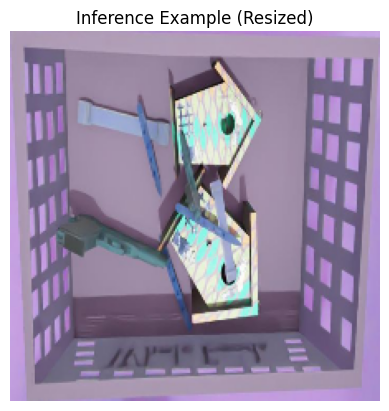

In [10]:
import matplotlib.pyplot as plt

def inference_example(folder_path):
    rgb_path = os.path.join(folder_path, 'rgb.jpg')
    pc_path = os.path.join(folder_path, 'pc.npy')

    rgb = cv2.imread(rgb_path)[:, :, ::-1]
    point_cloud = np.load(pc_path)

    # Convert point_cloud if needed (if it is image-like).
    if point_cloud.ndim == 3 and point_cloud.shape[0] == 3:
        point_cloud = np.transpose(point_cloud, (1, 2, 0))
        point_cloud = point_cloud.reshape(-1, 3)

    # Use the same transform as for validation.
    transform = A.Compose([A.Resize(224, 224)])
    rgb_aug = transform(image=rgb)['image']

    input_rgb = torch.from_numpy(rgb_aug).permute(2, 0, 1).unsqueeze(0).float().to(device)
    input_pc = torch.from_numpy(point_cloud).unsqueeze(0).float().to(device)

    model.eval()
    with torch.no_grad():
        pred_bbox = model(input_rgb, input_pc).cpu().numpy()[0]
    print("Predicted 3D BBox parameters:", pred_bbox)
    plt.imshow(rgb_aug)
    plt.title("Inference Example (Resized)")
    plt.axis("off")
    plt.show()

# Run inference on the first folder from the dataset.
inference_example(folders[0])


In [12]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 96.6 MB/s eta 0:00:00


In [13]:
dummy_rgb = torch.randn(1, 3, 224, 224).to(device)
dummy_pc = torch.randn(1, 1000, 3).to(device)  # Adjust number of points as needed
torch.onnx.export(model, (dummy_rgb, dummy_pc), "3dbbox_model.onnx", opset_version=11)
